In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

os.chdir("/content/drive/My Drive/Drive_space")

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
# LIST GPUS AVAILABLE
print(device_lib.list_local_devices())
import tensorflow.python.keras
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.compat.v1.Session(config=config) 
#tensorflow.python.keras.backend.set_session(sess)
tf.compat.v1.keras.backend.set_session(
    sess
)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11917369221176555885
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4061916337451553605
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
with open("dataset/images_3000_160.p", 'rb') as f:
    images = pickle.load(f)

with open("dataset/labels_3000_160.p","rb") as f:
    labels = pickle.load(f)

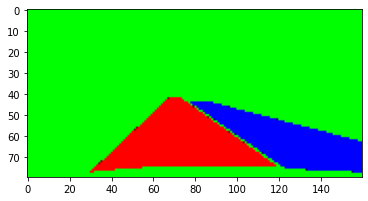

In [ ]:
# convert background to green
new_labels = []
for lab in labels:
    for x in range(lab.shape[0]):
        for y in range(lab.shape[1]):
            if (np.all(lab[x][y]==[0,0,0])):
                lab[x][y]=[0,1,0]
    new_labels.append(lab)

plt.imshow(new_labels[0])

In [ ]:
images = np.array(images)
labels  = np.array(new_labels)

#Shuffle
images, labels = shuffle(images, labels, random_state=4)

#Test size at 15%

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.15)
n_train = len(X_train)
n_val = len(X_val)

print("Number of elements in training set")
print(n_train)
print("Number of elements in validation set")
print(n_val)

Number of elements in training set
2550
Number of elements in validation set
450


UNET Model

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Conv2D, MaxPooling2D, Reshape, Input, Add, Resizing, ReLU
from keras.layers import UpSampling2D, Conv2DTranspose,  Concatenate
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

In [ ]:
def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2

def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

In [ ]:
def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(3, 1, padding="same", activation="softmax")(decoder_4)

    model = Model(input1, out)
    return model

In [ ]:
input_shape = (80, 160, 3)
model = U_Net(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 160, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 80, 160, 64)  1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 160, 64)  256        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

Training

In [ ]:
batch_size = 16
epochs = 10
pool_size = (2, 2)
learning_rate = 0.01
steps_per_epoch = len(X_train)/batch_size
input_shape = X_train.shape[1:]

In [ ]:

#model.compile()
optim = tf.keras.optimizers.Adam(learning_rate=learning_rate,  amsgrad=False, name="Adam")
model.compile(optimizer=optim, loss='categorical_crossentropy') 
#model.compile(optimizer=tf.keras.optimizers.Adam( learning_rate=learning_rate, amsgrad=False, name="Adam"), loss='categorical_crossentropy')
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=steps_per_epoch, 
          epochs=epochs, verbose=1,validation_data=(X_val, y_val) )



Epoch 1/10
318/318 [==============================] - 71s 217ms/step - loss: 0.3711 - val_loss: 0.5340
Epoch 2/10
318/318 [==============================] - 68s 213ms/step - loss: 0.2904 - val_loss: 0.3567
Epoch 3/10
318/318 [==============================] - 67s 212ms/step - loss: 0.2699 - val_loss: 0.3513
Epoch 4/10
318/318 [==============================] - 67s 212ms/step - loss: 0.2564 - val_loss: 0.3241
Epoch 5/10
318/318 [==============================] - 67s 211ms/step - loss: 0.2368 - val_loss: 0.2628
Epoch 6/10
318/318 [==============================] - 67s 211ms/step - loss: 0.2154 - val_loss: 0.2078
Epoch 7/10
318/318 [==============================] - 67s 211ms/step - loss: 0.1969 - val_loss: 0.3476
Epoch 8/10
318/318 [==============================] - 67s 211ms/step - loss: 0.1785 - val_loss: 0.2169
Epoch 9/10
318/318 [==============================] - 67s 210ms/step - loss: 0.1675 - val_loss: 0.2337
Epoch 10/10
318/318 [==============================] - 68s 213ms/step - l

In [ ]:
model.save('unet_epoch_10.h5')

dict_keys(['loss', 'val_loss'])


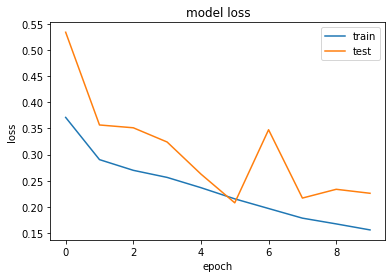

In [ ]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Testing

In [ ]:
def rgb_channel(img, thresholding=False, thresh=220):
    """Threshold the re-drawn images
    Returns R, G, B channels"""
    image = np.copy(img)
    if thresholding:
        ret, image = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    return R,G,B

In [ ]:
def run(input_image):
    h,w,d = input_image.shape
    network_image = input_image.copy()
    network_image = cv2.resize(network_image, (160,80), interpolation=cv2.INTER_AREA)
    network_image = network_image[None,:,:,:]
    prediction = model.predict(network_image)[0]*255
    R,G,B = rgb_channel(prediction, thresholding=True, thresh = 50)
    #plt.imshow(R)
    blank = np.zeros_like(R).astype(np.uint8)
    lane_image = np.dstack((R,blank, B))
    lane_image = cv2.resize(lane_image, (w,h))
    result = cv2.addWeighted(input_image, 1, lane_image.astype(np.uint8), 1, 0)
    return result

Text(0.5, 1.0, 'Drawn Prediction')

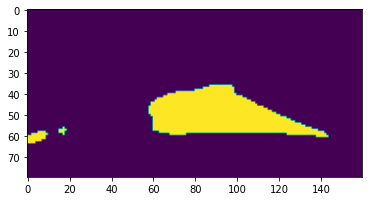

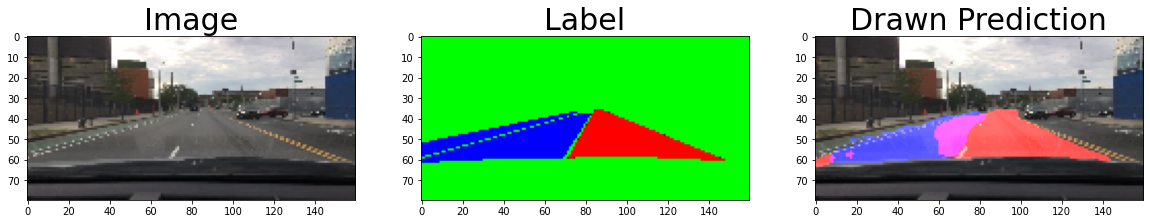

In [ ]:
index = random.randint(0,len(images))

img_test = run(images[index])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,20))
ax1.imshow(images[index].squeeze())
ax1.set_title('Image', fontsize=30)
ax2.imshow(labels[index].squeeze())
ax2.set_title('Label', fontsize=30)
ax3.imshow(img_test)
ax3.set_title("Drawn Prediction", fontsize=30)

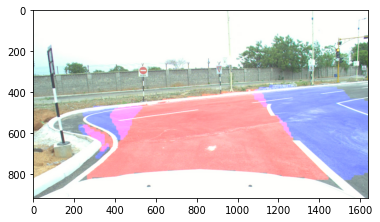

In [ ]:
predict_image = mpimg.imread("/content/drive/My Drive/Drive_space/testbed1.jpg")
plt.imshow(run(predict_image))
plt.show()